In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/d2l.ai_implementation/chapter12')

In [5]:
from ObjectDetection import *
from BananaDetection import BananaDetection

In [6]:
PATH = '/content/drive/MyDrive/d2l.ai_implementation/datasets/banana-detection'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [7]:
batch_size = 32
num_classes = 1

In [8]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [9]:
train_data = BananaDetection(PATH, is_train=True)
val_data = BananaDetection(PATH, is_train=False)

train_iter = DataLoader(train_data, batch_size, shuffle=True)
val_iter = DataLoader(val_data, batch_size)

In [10]:
model = TinySSD(num_classes)

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.2, weight_decay=5e-4)

In [12]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [13]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [14]:
num_epochs = 20

model = model.to(DEVICE)
model.train()
cls_errs, bbox_maes = [], []
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error

    cls_err, bbox_mae = 0, 0
    cls_count, bbox_count = 0, 0

    for features, target in train_iter:

        X, Y = features.to(DEVICE), target.to(DEVICE)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = model(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)

        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()

        cls_err += cls_eval(cls_preds, cls_labels)
        cls_count += cls_labels.numel()
        bbox_mae += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        bbox_count += bbox_labels.numel()

    cls_err, bbox_mae = 1 - cls_err / cls_count, bbox_mae / bbox_count
    cls_errs.append(cls_err)
    bbox_maes.append(bbox_mae)

    print(f'epoch {epoch + 1}, class err {cls_err:.3f}, bbox mae {bbox_mae:.3f}')

epoch 1, class err 0.021, bbox mae 0.005
epoch 2, class err 0.005, bbox mae 0.005
epoch 3, class err 0.005, bbox mae 0.005
epoch 4, class err 0.005, bbox mae 0.005
epoch 5, class err 0.005, bbox mae 0.005
epoch 6, class err 0.004, bbox mae 0.005
epoch 7, class err 0.004, bbox mae 0.004
epoch 8, class err 0.004, bbox mae 0.004
epoch 9, class err 0.004, bbox mae 0.004
epoch 10, class err 0.004, bbox mae 0.004
epoch 11, class err 0.004, bbox mae 0.004
epoch 12, class err 0.004, bbox mae 0.004
epoch 13, class err 0.004, bbox mae 0.004
epoch 14, class err 0.004, bbox mae 0.003
epoch 15, class err 0.003, bbox mae 0.003
epoch 16, class err 0.003, bbox mae 0.003
epoch 17, class err 0.003, bbox mae 0.003
epoch 18, class err 0.003, bbox mae 0.003
epoch 19, class err 0.003, bbox mae 0.003
epoch 20, class err 0.003, bbox mae 0.003


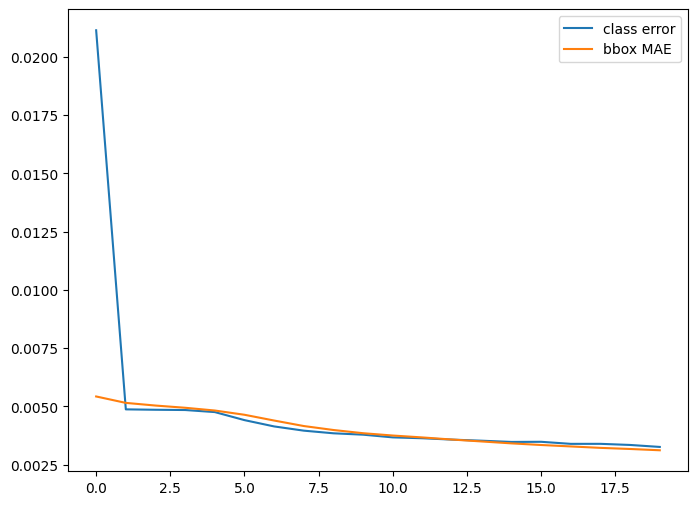

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(cls_errs, label='class error')
plt.plot(bbox_maes, label='bbox MAE')
plt.legend()

plt.show()